## Tutorial: Dropout as Regularization and Bayesian Approximation

This tutorial is taken from: https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/ (Weidong Xu, Zeyu Zhao, Tianning Zhao)

**Abstract**: This tutorial aims to give readers a complete view of dropout, which includes the implementation of dropout (in PyTorch), how to use dropout and why dropout is useful. 

Basically, dropout can 
- (1) reduce overfitting (so test results will be better) and 
- (2) provide model uncertainty like Bayesian models we see in the class (Bayesian Approximation).

**Warning**: Some parts of the notebook is very slow to run so we commented them out with triple quotes and provided the saved models and results (see above link). To re-run those parts, you will need to uncomment the code and run with GPU and CUDA support. Except the commented part, this notebook can run without GPU (as long as you downloaded our models). We trained our models on Nvidia GTX 1080 Ti GPU and it takes at least 15 hours to train all models in this notebook.

## 1. Introduction
Deep neural network is a very powerful tool in machine learning. Multiple non-linear hidden layers enable the model to learn complicated relationships between input and output. However, when the training set is small, there are different parameter settings that would fits training set perfectly, but the one complex parameter setting tends to perform poorly on the test dataset, ie we got the problem of **overfitting**. 

One way to solve this problem is by averaging predictions of different neural networks , but this becomes computationally expensive when applied to large datasets. The alternative that makes it possible to train a huge number of different networks in a reasonable time is dropout, which randomly omits some hidden units i.e. feature detectors to prevent co-adaption and samples from an exponential number of different “thinned” networks. The idea of dropout model can be shown as below [[3](#Reference)]. Applying dropout to a neural network amounts to sampling a “thinned” network from it, where you cut all the input and output connections for the dropped units. Training process for that would be like training a number of thinned networks with extensive weight sharing. But when it comes to testing, averaging predictions over different networks seems to be unfeasible, so a single network with scaled weights for all the units was used.

<img src="../imgs/dropout001.png" alt="Drawing" style="width: 550px;"/>

A motivation for dropout comes from a theory of the role of sex in evolution, where half genes come from each parent, combine and mutate a little. This turns out to be a bery efficient way which most advanced organisms used to evolve, although it seems to break up the complicated co-adaption that has survived through natural selection. But the truth is that the criterion for natural selection may not be individual fitness but rather mix-ability of genes, which is exactly the same as our neural network. We want a network that not only performs well on the existing training datasets, but we also expect it to predict reasonably in the unseen future.

Besides letting the network predict future data better (reduce overfitting), the dropout also enables us to obtain the model uncertainty. While predicting new data, instead of using all neurons (disabling dropout layers), we can keep dropout enabled and predict multiple times. Intuitively, our model is able to give different predictions since different combinations of neurons are used for prediction. In addition, this method is actually Bayesian (see details in the following section).

Mathematical background can be access through original article.

## 3. Dropout Implementation

All our implementations are based on PyTorch. The model training is on GPU and all other tasks are on CPU (so readers who don't have GPUs can run our notebook). To switch between GPU/CPU, you can add/remove `.cuda()` in the code.

### Import libraries

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

### Dropout Implementation

Below is the dropout layer we implemented, based on PyTorch.

We should multiply the dropout output by $\frac{1}{1-p}$ where $p$ is the dropout rate to compensate for the dropped neurons. We implemented a dropout layer below, it should have same functionality as `nn.Dropout` in Pytorch.

We used `MyDropout` in our first example network as a demonstration of its functionality; we managed to reproduce the results when replacing `MyDropout` by `nn.Dropout` (data not shown). We used `nn.Dropout` for all remaining networks since `nn.Dropout` is more efficient than our implementation.

In [2]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        # multiplier is 1/(1-p). Set multiplier to 0 when p=1 to avoid error...
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        # if model.eval(), don't apply dropout
        if not self.training:
            return input
        
        # So that we have `input.shape` numbers of Bernoulli(1-p) samples
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        
        # To support both CPU and GPU.
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
            
        # Multiply output by multiplier as described in the paper [1]
        return torch.mul(selected_,input) * self.multiplier_

## 4. Dropout as Regularization

In this section, we want to show dropout can be used as a regularization technique for deep neural networks. It can reduce the overfitting and make our network perform better on test set (**like L1 and L2 regularization we saw in AM207 lectures**). We will first do a multilayer perceptron (fully connected network) to show dropout works and then do a LeNet (a convolutional neural network) to show dropout is also useful for different network architectures.

We use MNIST (as we see in homework) as our sample dataset. This dataset has images of hand written digits and the labels of the ground truth digits. Code cell below loads the dataset and shows 10 training samples.

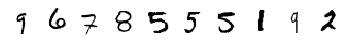

label: [9 6 7 8 5 5 5 1 9 2]
image data shape: (1, 28, 28)


In [3]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST(root='/home/kundan/MEGA/DatabaseLocal/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='/home/kundan/MEGA/DatabaseLocal/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)

### 4.1 Multilayer Perceptron

We first build a multilayer perceptron (MLP), and use the code below to define the network as described in paper [[1](#Reference)]. This network has 2 hidden layer with 800 hidden units per hidden layer. To show our implementation of Dropout above is correct, we use `MyDropout` here.

In [10]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",MyDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        
        # Add hidden layers
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), MyDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))        
        
    def forward(self, x):
        # Turn to 1D
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x

In [11]:
model = MLP()
print(model)

MLP(
  (model): Sequential(
    (dropout0): MyDropout()
    (input): Linear(in_features=784, out_features=800, bias=True)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout()
    (hidden1): Linear(in_features=800, out_features=800, bias=True)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10, bias=True)
  )
)


Next, we implement a sklearn-like classifier for training and keep track of the **full test results** after each epoch.

In [13]:
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=128, max_epoch=10, \
                 lr=0.1, momentum=0):
        # Wrap MLP model
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        # Training, make sure it's on GPU, otherwise, very slow...
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        # Used to keep all test errors after each epoch
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

Paper [[1](#Reference)] tried three sets of experiments. One with **no dropout**, one with **dropout (0.5) in hidden layers** and one with **dropout in both hidden layers (0.5) and input (0.2)**. We use the same dropout rate as in paper [[1](#Reference)]. We define those three networks in the code section below.

The training takes a lot of time and **requires GPU and CUDA**, and therefore, we provide the trained model and commented out the training part. If readers want to train the models themselves, they can simply uncomment the training code.

In [17]:
import sys
sys.path.insert(0, './SavedModels/')

hidden_layers = [800, 800]

### Below is training code, uncomment to train your own model... ###
### Note: You need GPU to run this section ###
'''
# Define networks
mlp1 = [MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=1500), 
        MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=1500),
        MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=1500)]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(trainset, testset,verbose=False) for mlp in mlp1]

# Save torch models
for ind, mlp in enumerate(mlp1):
    torch.save(mlp.model, 'mnist_mlp1_'+str(ind)+'.pth')
    # Prepare to save errors
    mlp.test_error = list(map(str, mlp.test_error))

# Save test errors to plot figures
open("mlp1_test_errors.txt","w").write('\n'.join([','.join(mlp.test_error) for mlp in mlp1])) 
'''

# Load saved models to CPU
mlp1_models = [torch.load('SavedModels/mnist_mlp1_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1,2]]

# Load saved test errors to plot figures.
mlp1_test_errors = [error_array.split(',') for error_array in open("SavedModels/mlp1_test_errors.txt","r").read().split('\n')]
mlp1_test_errors = np.array(mlp1_test_errors,dtype='f')

After the training, we can plot the number of error predictions on test set after each epoch for all three networks as in paper [[1](#Reference)]. `y-axis` means how many samples in the test set our network does not predict correctly.

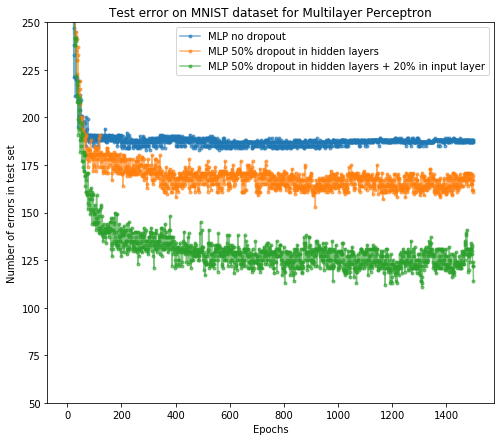

In [19]:
labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()

From the result, we see dropout as regularization is useful and it successfully improves the network accuracy on the test set. In addition, further adding the dropout layer after the input layer will help as well.

### 4.2 Convolutional Neural Network (LeNet)

Next, we show dropout can improve test performance in convolutional neural networks as well (i.e. **dropout as regularization is generalizable among different network architectures**). Here, we implement a simple LeNet for demonstration. The LeNet architecture is shown below.

<img src="../imgs/dropout002.png" alt="Drawing" style="width: 600px;"/>

source: https://blog.dataiku.com/deep-learning-with-dss

We first calculate the dimension of images after going through convolutional layers and pooling layers since we need to specify in and out dimensions for linear layers in `pytorch`.

## Reference

[1] [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580.pdf)

[2] [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf)

[3] [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf)